In [1]:
import os
import subprocess
import matplotlib.pyplot as plt

import scipy.stats as sps
from scipy import stats
import numpy as np
import pandas as pd
import pkg_resources
#pkg_resources.require("seaborn==0.11.0")
import seaborn as sns
import pylab
import random
from scipy.stats import qmc

import re
import array

from sympy import S
from sympy.physics.wigner import clebsch_gordan
from sympy.physics.wigner import racah
from sympy.physics.wigner import wigner_3j
from sympy.physics.wigner import wigner_6j
import numpy as np
from __future__ import division
import scipy as sci
import scipy.special as sp
from scipy.integrate import dblquad
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import qmc
import os
import datetime
import time
import scipy.stats as sps
from multiprocessing import Pool
from itertools import repeat
import random
import math
from scipy.integrate import odeint
from IPython.display import display, clear_output,set_matplotlib_formats
import matplotlib.cm as cm
import matplotlib.ticker
import matplotlib.mlab as mlab
import sys
from scipy.stats import norm

import numpy as np
from scipy.integrate import tplquad

#plt.style.use('science')
plt.rcParams.update({'font.size': 12})
gr = 4
h = 3

In [2]:
os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

In [3]:
def latin_sampling_3(samples):
    
    '''Given a number of samples, generate a training array.'''
    
    #n_train = 50
    
    random.seed(142857)

    
    Vv0 = 51.8

    Rv0 = 1.17

    av0 = 0.75
    
    ## Central value of parameter values
    alphaCentral = np.array([Vv0, Rv0, av0])


    #Creating a scale for how much the parameters will wiggle. Afterwards we sample from a latin hyper cube for training,
    #but use this scales also for the testing sampling which we do it with a Gaussian
    scaleTraining=0.3

    bounds_Vv_Scale = abs(Vv0*(scaleTraining))

    bounds_Rv_Scale = abs(Rv0*(scaleTraining))

    bounds_av_Scale = abs(av0*(scaleTraining))

    bounds_alpha=[bounds_Vv_Scale,bounds_Rv_Scale,bounds_av_Scale]
    
    bounds_Vv = [Vv0-bounds_Vv_Scale, Vv0+bounds_Vv_Scale]

    bounds_Rv = [Rv0-bounds_Rv_Scale, Rv0+bounds_Rv_Scale]

    bounds_av = [av0-bounds_av_Scale, av0+bounds_av_Scale]


    ## Bound array of the latin hypercube, min and max of the cube array in the form 
    ## array = [[V_min,V_max],[r_min,r_max],..]
    ##dim= (7,2)
    bounds = np.array([
    
        bounds_Vv,
        bounds_Rv,
        bounds_av,
    
    ])

    #random sampling inside the cube and creates the training potential array
    sampler = qmc.LatinHypercube(d=len(bounds))
    #sample = sampler.random(n_train)

    ## This is the array of (50,7) with the correct parameters. 
    ## This is important!!!!
    #train = qmc.scale(sample, bounds[:, 0], bounds[:, 1])

    #potential empirical interpolation method, number of training parameters
    #n_train_EIM=1000
    random.seed(142857)
    sample_EIM = sampler.random(samples)
    ## training set parameters for the optica potential emulator
    train_EIM = qmc.scale(sample_EIM, bounds[:, 0], bounds[:, 1])
    
    return train_EIM

In [4]:
def generate_input_file_elastic(parameter_values):
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")
    file = 'frescox_inputs/12C_n_el_template.in'

    with open(file) as f:
        content = f.readlines()
        
    no_p = 0;
    for idx, line in enumerate(content):
        if 'XXXXX' in line:
            no_param = line.count('XXXXX')
            line_temp = line
            for i in range(no_param):
                line_temp = line_temp.replace("XXXXX", str(parameter_values[no_p]), 1) 
                no_p += 1
    
            content[idx] = line_temp
    
    f = open("frescox_inputs/frescox_el_temp_input.in", "a")
    f.writelines(content)
    f.close()


def extract_partial_waves(file_extract='fort.17'):
    '''
    this code extracts from the fort.17 file the partial waves and adds them as dictionary with the keys
    corresponding to the different quantum numbers of the coupled set of differential equations. The keys are
    broken down as follows {coupled channel set,channel number,l',j',J, l, j}.
    '''
    keys_array = []
    
    # Initialize a dictionary to store the values
    data_dict = {}

    # Initialize a counter for lines starting with "401"
    count_401 = 0

    # Specify the file path
    file_path = 'fort.17'

    # Regular expression pattern to match lines with the desired format
    pattern = re.compile(r'^\s*(\d+\s+\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\s+\d+\.\d+)')
    
    pattern2 = re.compile(r'^\s*201\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+-1\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+\s+\d+\.\d+')

    pattern3 = re.compile(r'^\s*-1\s+0\s+0\.0\s+0\.0\s+0\s+0\.0\s+0\.0{10}\s+0\.0{10}\s+0\.0{8}')

    # Open the file and read its contents
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
    # Initialize a variable to hold the current key
    current_key = None

    # Iterate through the lines to find lines that match the pattern
    for i in range(len(lines)):
        line = lines[i].strip()
        match = pattern.match(line)
        if match:
            # Convert the first 6 values of the line to floats and use them as part of the key
            key_values = match.group(1).split()[:6]
            key_values = [float(value) for value in key_values]
            current_key = tuple([count_401] + key_values)
            # Initialize an empty list for the values associated with the key
            data_dict[current_key] = []
            i += 1  # Move to the next line to start reading values
            while i < len(lines)  and not lines[i].startswith("1001"):
                # Split the current line into values
                line2 = lines[i].strip()
                match2 = pattern.match(line2)
                line4 = lines[i].strip()
                match4 = pattern3.match(line2)
                if match2:
                    break
                if match4:
                      i+=1
                else:
                    values = lines[i].split()
                    # Convert values to floats and append them to the current key's list
                    data_dict[current_key].extend([float(value.replace('D', 'E')) for value in values])
                    i += 1
        elif lines[i].startswith("1001"):
            # Increment the counter for lines starting with "401"
            count_401 += 1
    
    keys_array = list(data_dict.keys())
  
    
    return data_dict, keys_array



def wave_functions_format_imaginary(file_extract='fort.17'):
    '''
    This function takes as input the fort.17 file and using the keys from the function extract_partial_waves
    then writes the wavefunction from the fresco output to \psi= real + imag
    '''
    waves_exact = {}
    
    data_dict, keys_array = extract_partial_waves()
    
    for key in keys_array:
        temp_real_array = []
        temp_imag_array = []
        temp_wave = data_dict.get(key)
        for i in range(len(np.array(temp_wave))):
            radial = temp_wave[i]
            if (i % 2 != 0):
                temp_imag_array.append(radial)
            if (i % 2 == 0) :
                temp_real_array.append(radial)
                
        waves_exact[key] = np.array(temp_real_array) + 1j* np.array(temp_imag_array)
        
        
    return waves_exact, keys_array


def frescox_output_elastic_wavefunctions(input_file='frescox_inputs/frescox_el_temp_input.in',
                   output_file='fort.17'):
    '''
    this function reads in the frescox input file formatted through the generated input file function
    runs it and extracts the partial wave functions with the respective keys corresponding to the quantum
    numbers.
    '''

    commands = '''
      cd ~/fewbody/bandframework/software/Bfrescox/Tutorial_I/python_scripts
      mkdir frescox_outputs
      ~/fewbody/Frescoxex/frescox < frescox_inputs/frescox_el_temp_input.in > frescox_outputs/test_temp.out
    '''

    # Execute frescox
    bashresults = subprocess.run(commands, capture_output=True, shell=True)

    # Read outputs
    #os.chdir("bandframework/software/Bfrescox/Tutorial_I/python_scripts")

    waves, keys = wave_functions_format_imaginary(output_file)
    
        
    os.remove(input_file)
    os.remove(output_file)
    
    return waves, keys



def frescox_run_elastic_waves(theta):
    '''
    This function takes as an input a set of parameters and for each parameter set generates a frescox
    input using the template form, and then runs frescox and extracts the wave functions. the outputs 
    are an array whose elements are dictionaries of the different partial waves corresponding to
    each set of paramters in theta, and the keys to the dictionaries.
    '''
    theta_list = theta.tolist()
    waves_array = []
#    keys_array = []
    for para_obs in theta_list:
        #para_obs += [3.5,1,0.3]
        generate_input_file_elastic(para_obs)
        waves_per_calc, keys_per_calc  = frescox_output_elastic_wavefunctions()
        waves_array.append(waves_per_calc)
#        keys_array.append(keys_per_calc)

    return waves_array, keys_per_calc

In [180]:
theta_tr = latin_sampling_3(20)

In [626]:
a_comp,b_comp = frescox_run_elastic_waves(theta_tr)
r = np.linspace(0.04,40.04,1001)


In [627]:
print(r)

[4.000e-02 8.000e-02 1.200e-01 ... 3.996e+01 4.000e+01 4.004e+01]


In [628]:
print(b_comp)

[(1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (2, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (3, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0), (4, 1.0, 3.0, 3.0, 3.0, 3.0, 3.0)]


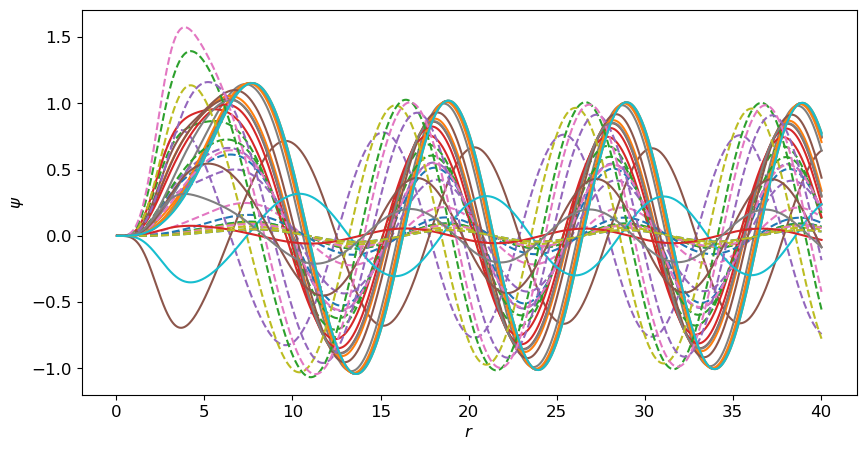

In [738]:
#extract some frescox wavefunctions and plot to see what they look like.
wave_set = []
for i in range(len(a_comp)):
    #print(np.gradient(a_comp[i].get(b_comp[0]))[0])
    wave_keyed = a_comp[i].get(b_comp[3])
    wave_set.append(wave_keyed)
#print(np.shape(wave_set))


wave_rescaled = wave_set

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(20):
    ax.plot(r, np.imag(wave_set[i]), zorder=1,linestyle='--',label='imag')
    ax.plot(r, np.real(wave_set[i]), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

In [739]:
def Gamow_factor(l, eta):
    r'''This returns the... Gamow factor.
    See [Wikipedia](https://en.wikipedia.org/wiki/Gamow_factor).

    Parameters:
        l (int): angular momentum
        eta (float): Sommerfeld parameter (see
            [Wikipedia](https://en.wikipedia.org/wiki/Sommerfeld_parameter))
    
    Returns:
        C_l (float): Gamow factor

    '''
    if eta == 0.0:
        if l == 0:
            return 1
        else:
            return 1 / (2*l + 1) * Gamow_factor(l-1, 0)
    elif l == 0:
        return np.sqrt(2*np.pi*eta / (np.exp(2*np.pi*eta)-1))
    else:
        return np.sqrt(l**2 + eta**2) / (l*(2*l+1)) * Gamow_factor(l-1, eta)


def find_smallest_nonzero(wave):
    '''
    given an array, it finds the smallest value matchin the r0 condition bellow starting from the beginning. 
    this will ensure we do not divide by 0.
    '''
    i = 0
    while np.abs(wave[i]) < 0.005: ##condition
        i += 1
        minimum = wave[i]
        a = i
        #print(i)
    return minimum, a

def rescaling_function(wave,keys,l):
    '''
    normalizes the wave near zero in this manner: 
    psi' = C_l*psi*r0^(l+1)/psi(r0)
    '''
    mini, i0 = find_smallest_nonzero(wave[0].get(keys[l]))
    wave_res = []
    for i in range(len(wave)):
        w_keyed = Gamow_factor(l,0)*((r[i0])**(l+1))*(wave[i].get(keys[l]))/(wave[i].get(keys[l]))[i0]
        wave_res.append(w_keyed)
    return np.array(wave_res)

In [750]:
rescaled_wave = rescaling_function(a_comp,b_comp,0)

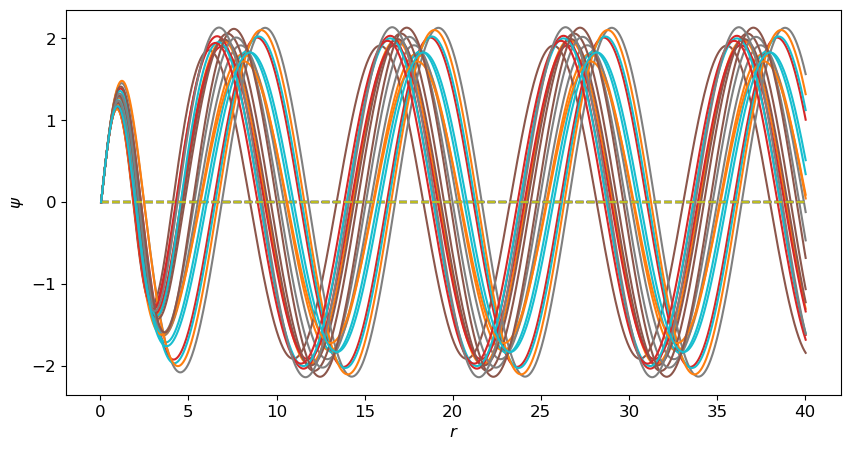

In [751]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(20):
    ax.plot(r, np.imag(rescaled_wave[i]), zorder=1,linestyle='--',label='imag')
    ax.plot(r, np.real(rescaled_wave[i]), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

In [742]:
theta_tr[0]

array([47.77630649,  1.15227033,  0.57630038])

In [752]:
energy = 9.2307
mass_target = 12.00
mass_coeff = mass_target**(1/3)
mass_nucleon = 931
hbarc = 197 # MeV • fm
reduced = (mass_target*935*1*935)/((mass_target+1)*935)
k = np.sqrt((2*reduced*energy)/(hbarc**2))

####
l_val = 0
r_val = 0
####

hbar2_mu = (hbarc**2)/(2*reduced)

alpha = [47.77630649,1.15227033*mass_coeff,0.57630038]


In [753]:
print(r)

[4.000e-02 8.000e-02 1.200e-01 ... 3.996e+01 4.000e+01 4.004e+01]


In [754]:
print(np.shape(wave_set))

(20, 1001)


In [755]:
##now lets add the centrifugal part of the potential
def centrifugal(l,x):
    '''with a radia grid x, generate an array containing the centrifugal potential'''
    return (l*(l+1))/(x**2)


# generate a radial second derivative in a 5 point grid
def generate_second_derivative_matrix(xgrid):
    
    '''
    For a given grid of points, compute the second derivative in 5 points
    '''
    N = len(xgrid)
    dx = xgrid[1]-xgrid[0]
    
    # Generate the matrix for the second derivative using a five-point stencil
    main_diag = np.ones(N) * (-5.0 /2 / dx**2)
    off_diag = np.ones(N - 1)* 4/3 / dx**2
    off_diag2 = np.ones(N - 2) * (-1.0 / (12 * dx**2))
    
    D2 = np.diag(main_diag) + np.diag(off_diag, k=1) + np.diag(off_diag, k=-1) + np.diag(off_diag2, k=2) + np.diag(off_diag2, k=-2)
    return D2

def second_derivative_SVD(waves_array ,D2):
    '''
    obtain the second derivative of the fixed SVD components, from SVD outputs and second derivative matrix
    '''
    der2 = D2 @ np.array(waves_array).T

    return der2

def wood_saxon_potential(r,alpha):
    '''
    From the previously defined angular momentum components of the deformation introduce a deformation
    parametrized by  "beta2"
    '''
    v0,r0,a0 = alpha
    #R = R0 #- beta2*(sp.sph_harm(m_deform, l_deform, phi, theta))
    return (-v0/(1 + np.exp((r - r0)/a0)))


In [756]:
D2 = generate_second_derivative_matrix(r)
d2 = second_derivative_SVD(rescaled_wave,D2)
drop = 2

In [757]:
F =  - hbar2_mu*d2.T[r_val][drop:-drop] + hbar2_mu*centrifugal(l_val,r)[drop:-drop]*rescaled_wave[r_val][drop:-drop]\
        + wood_saxon_potential(r,alpha)[drop:-drop]*rescaled_wave[r_val][drop:-drop] \
        - energy*rescaled_wave[r_val][drop:-drop]
        

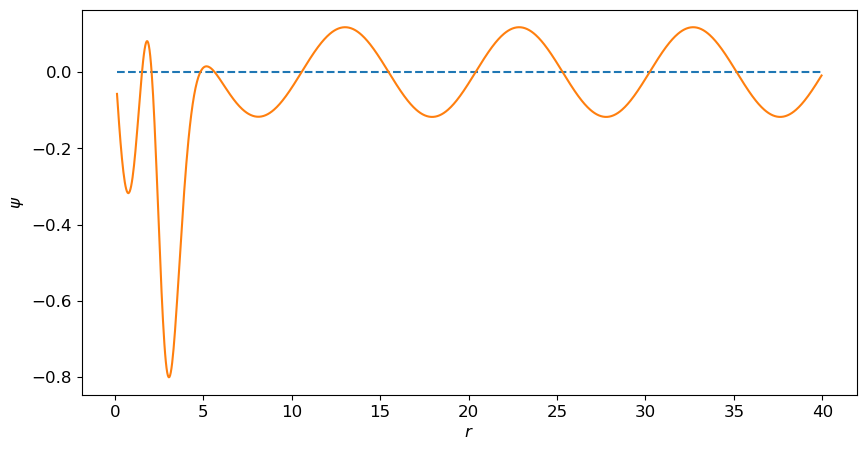

In [758]:

# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
ax.plot(r[drop:-drop], np.imag(F), zorder=1,linestyle='--',label='imag')
ax.plot(r[drop:-drop], np.real(F), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

# Something seems to be wrong, I will now try the case where V0, r0 and a0 are set to zero

In [724]:
zeros = np.array([[0,0,0]])

r = np.linspace(0.04,40.04,1001)

a_zero,b_zero = frescox_run_elastic_waves(zeros)

In [725]:
print(b_zero[0])

(1, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)


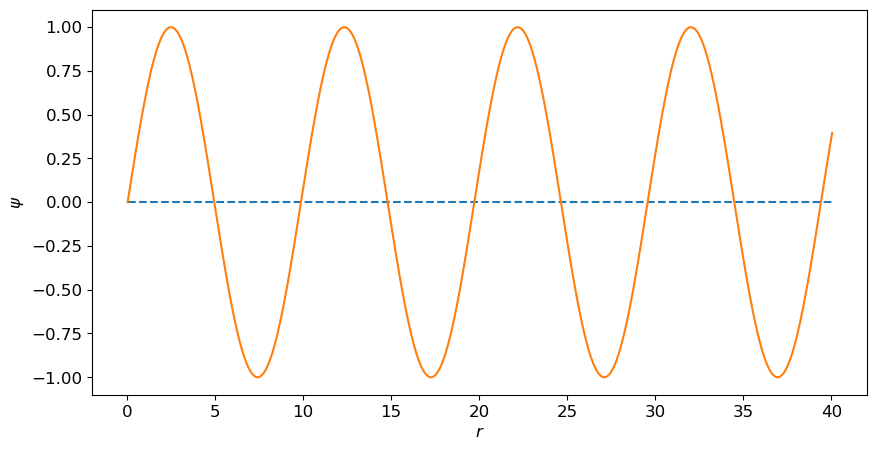

In [730]:
#extract some frescox wavefunctions and plot to see what they look like.
wave_zero = []
for i in range(len(a_zero)):
    #print(np.gradient(a_comp[i].get(b_comp[0]))[0])
    wave_keyed = a_zero[i].get(b_zero[0])
    wave_zero.append(wave_keyed)
#print(np.shape(wave_set))




# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
for i in range(1):
    ax.plot(r, np.imag(wave_zero[i]), zorder=1,linestyle='--',label='imag')
    ax.plot(r, np.real(wave_zero[i]), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

In [731]:
d2_zero = second_derivative_SVD(wave_zero,D2)
drop = 2
print(np.shape(d2_zero))
D2 = generate_second_derivative_matrix(r)


(1001, 1)


In [734]:
F =  - hbar2_mu*d2_zero.T[0][drop:-drop] + hbar2_mu*centrifugal(0,r)[drop:-drop]*wave_zero[0][drop:-drop] \
        - energy*wave_zero[0][drop:-drop]

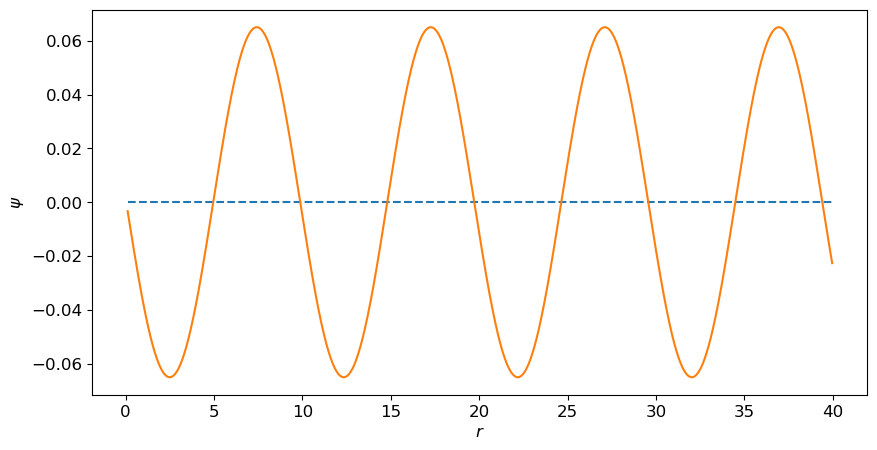

In [735]:
# Observe simulation outcomes
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)  
ax.plot(r[drop:-drop], np.imag(F), zorder=1,linestyle='--',label='imag')
ax.plot(r[drop:-drop], np.real(F), zorder=1,label='real')
plt.xlabel(r'$r$')
plt.ylabel(r'$\psi$')
#plt.legend()
#ax.set_yscale('log')
pylab.show()

In [621]:
print(r)

[4.000e-02 8.000e-02 1.200e-01 ... 3.996e+01 4.000e+01 4.004e+01]
